# Introduction

In this brief experiment, we explore the ability of neural networks to learn well known functions, like polynomials, sinusoids, and others. 

My impression has been that a deep enough network can more or less approximate anything we'd need, but how true is this? Moreover, how big do we need to get? 

While more layers allows for more interaction from different weights, we never can actually get a squared or cubed term. The activation functions we choose will be really important since our networks will be quite small. I imagine choosing the popular ReLU might tie our hands and make it more difficult to model functions. Other activation functions that make use of exponentials could be better, but will they generalize? 

This notebook will be an exercise in writing scaffolding code that can easily be modified to manipulate our network and data inputs. It will also be a cool exercise in function approximation and neural network generalizability. My hunch (not really founded on any basis) is that a network with maybe 3 layers and 10-15 nodes should be able to model the data well, but generalizability will be poor.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import copy
import math
from sklearn.model_selection import train_test_split

# Data

Let's get some data! We'll be using functions from $\mathbb{R} \rightarrow \mathbb{R}$. 

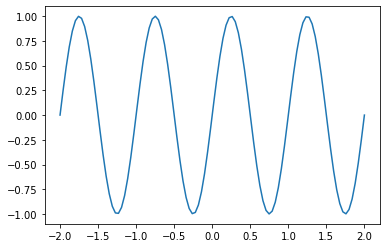

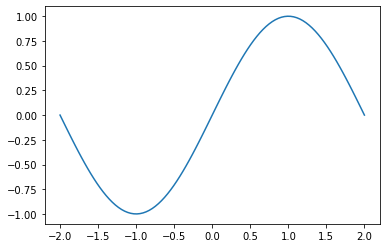

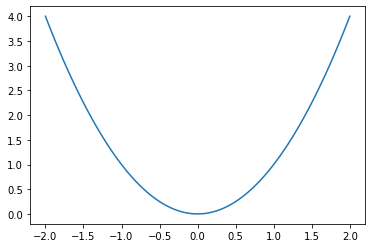

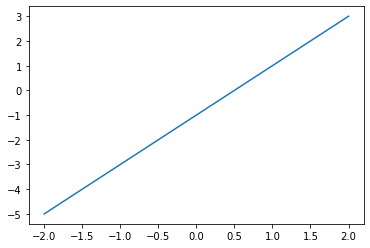

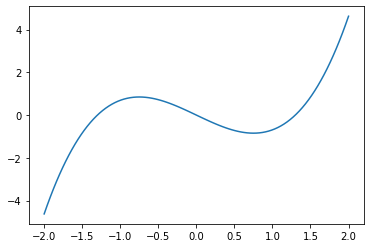

In [ ]:
def get_data(func, xmin=-2, xmax=2):
  xs = np.linspace(xmin, xmax, num=100)
  ys = [func(x) for x in xs]
  plt.plot(xs, ys)
  plt.show()
  return (xs, ys)



fastsin_data = get_data(lambda x: math.sin(x * 2 * math.pi))
slowsin_data = get_data(lambda x: math.sin(x * 0.5 * math.pi))
quad_data = get_data(lambda x: x ** 2)
line_data = get_data(lambda x: 2*x - 1)
cub_data = get_data(lambda x: (x-1.3)*(x+1.3)*x)

that should suffice for now!

# Network

The goal here is to write code for a very easily modifiable multi-layer-perceptron. I think the parameters we can have for our network class are nodes per layer, number of layers, and activation function.

In [ ]:
class MLP(nn.Module):
  def __init__(self, nodes_per_layer=4, num_layers=2, activation= nn.Softplus()):
    ''' num_layers does not count input and output one-node layers '''
    super(MLP, self).__init__()
    num_nodes = [1] + [nodes_per_layer]*num_layers
    self.layers = [nn.Linear(num_nodes[i], num_nodes[i+1]) for i in range(len(num_nodes)-1)]
    self.main = nn.Sequential()
    for i in range(num_layers):
      self.main.add_module('layer_{}'.format(i), nn.Linear(num_nodes[i], num_nodes[i+1]))
      self.main.add_module('activation_{}'.format(i), activation)
    self.main.add_module('final_layer', nn.Linear(nodes_per_layer, 1))

  def forward(self, x):
    return self.main(x)

In [ ]:
model = MLP()
print(model)
model.forward(torch.Tensor([4]))

MLP(
  (main): Sequential(
    (layer_0): Linear(in_features=1, out_features=4, bias=True)
    (activation_0): Softplus(beta=1, threshold=20)
    (layer_1): Linear(in_features=4, out_features=4, bias=True)
    (activation_1): Softplus(beta=1, threshold=20)
    (final_layer): Linear(in_features=4, out_features=1, bias=True)
  )
)


tensor([0.1286], grad_fn=<AddBackward0>)

# Training

In [ ]:
def plot_results(model, data, title):
  ys = model(torch.Tensor(data[0]).reshape(len(data[0]),1)).detach().numpy()
  plt.plot(data[0], ys, '*')
  plt.plot(data[0], data[1], '.')
  plt.title(title)
  plt.show()


In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
      # apply a uniform distribution to the weights and a bias=0
      m.weight.data.uniform_(0.0, 1.0)
      m.bias.data.fill_(0)

In [ ]:
def train(data, nlayers, npl, epochs=300, display=False):
  model = MLP(num_layers=nlayers, nodes_per_layer=npl)
  weights_init(model)
  x_train, x_test, y_train, y_test = [torch.Tensor(arr) for arr in \
                                      train_test_split(data[0], data[1], test_size=0.2)]
  train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=80)
  test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=20)

  optimizer = optim.Adam(model.parameters(), lr=0.02)
  criterion = nn.MSELoss()

  for epoch in range(epochs):
    losses = []
    for phase in ['train', 'val']:
      if phase == 'train':
        loader = train_loader
        model.train()
      else:
        loader = test_loader
        model.eval()

      total_loss = 0
      for x, y in loader:
        optimizer.zero_grad()
        out = model(torch.unsqueeze(x, dim=1))
        loss = criterion(torch.squeeze(out), y)
        total_loss += loss.item() * x.size(0)
        if phase == 'train':
          loss.backward()
          optimizer.step()
      
      losses.append(total_loss / len(loader.dataset))

    if display and (epoch % 20 == 0 or epoch == epochs - 1):
      print("_"*60)
      print("Epoch: {}.....Train Loss: {:.4f}.....Validation Loss: {:.4f}" \
            .format(epoch, losses[0], losses[1]))
  title = '{} layers, {} nodes per layer'.format(nlayers, npl)
  plot_results(model, data, title)
  return losses

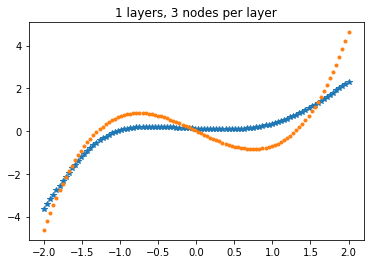

In [ ]:
# quad_mlp = train()
line_mlp = train(cub_data, 1, 3)

# Experiments

Let's inspect the effect of two independent variables: nodes per layer and number of layers.

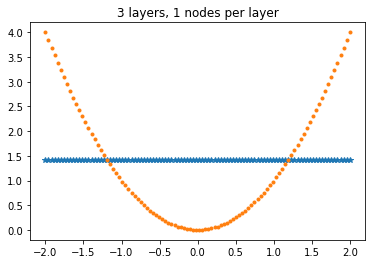

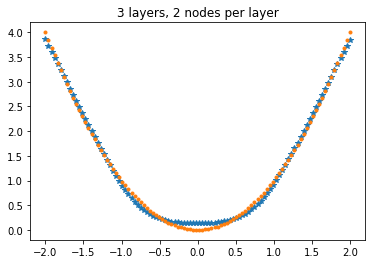

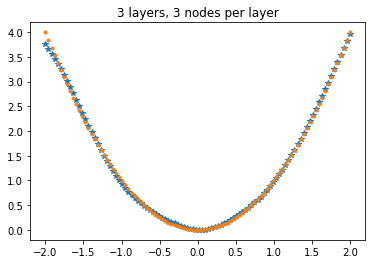

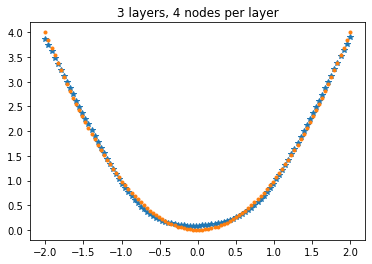

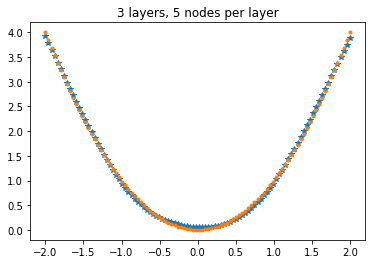

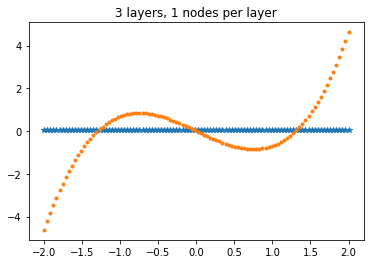

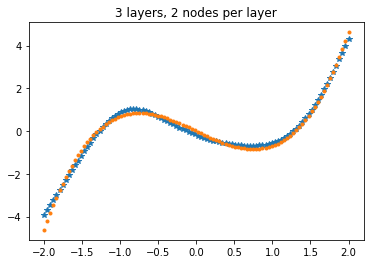

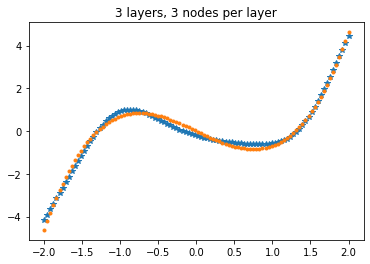

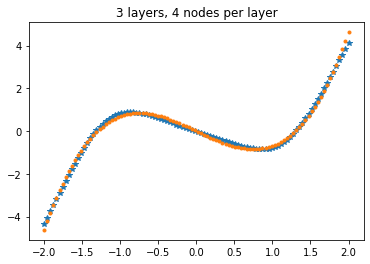

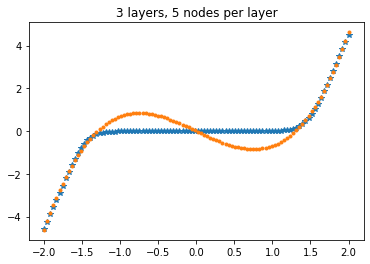

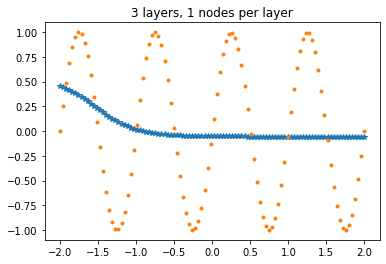

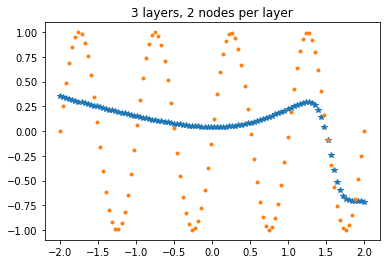

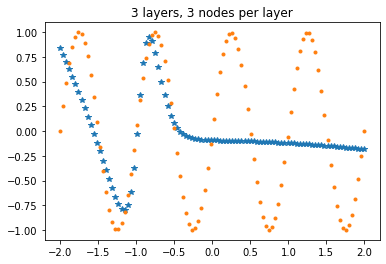

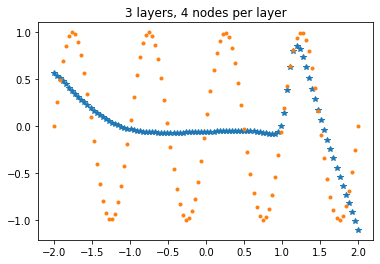

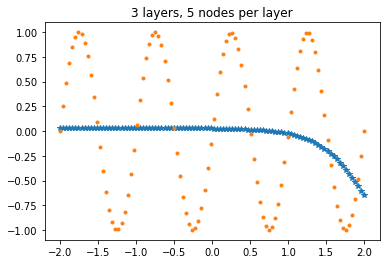

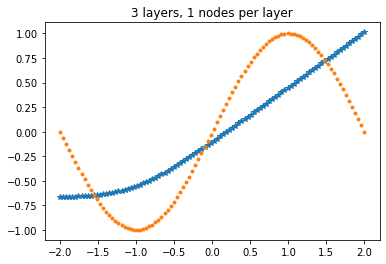

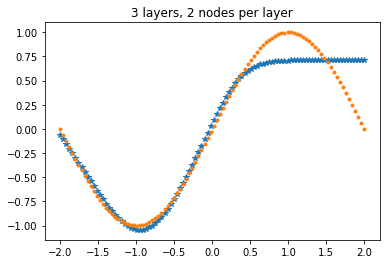

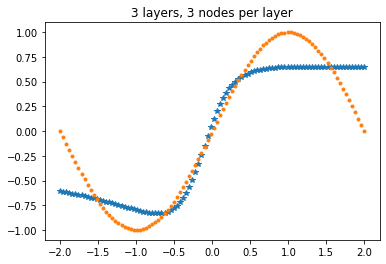

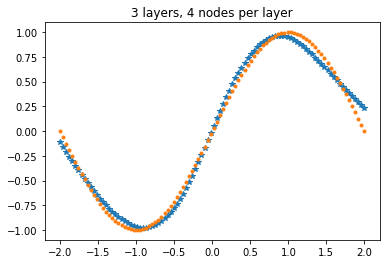

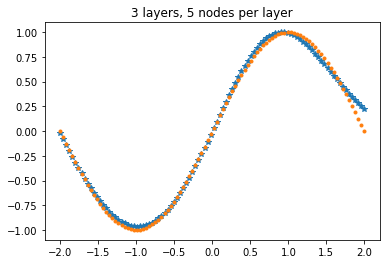

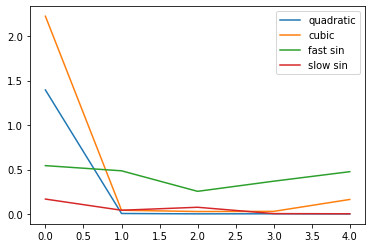

In [ ]:
npls = [1,2,3,4,5]
layers = [1,2,3,4,5]
datasets = [(quad_data, 'quadratic'), (cub_data, 'cubic'), \
            (fastsin_data, 'fast sin'), (slowsin_data, 'slow sin')]
losses_npl = [[]] * len(datasets)
for j, dataset in enumerate(datasets):
  losses = []
  for i, param in enumerate(params):
    plt.figure(1)
    losses.append(train(dataset[0], 3, param)[-1])
  losses_npl[j] = losses

for j, dataset in enumerate(datasets):
  plt.plot(losses_npl[j], label=dataset[1])
plt.legend()


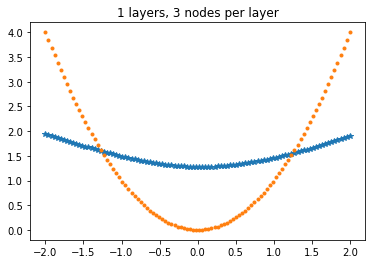

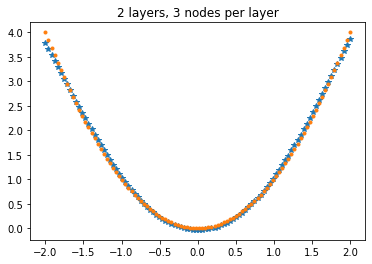

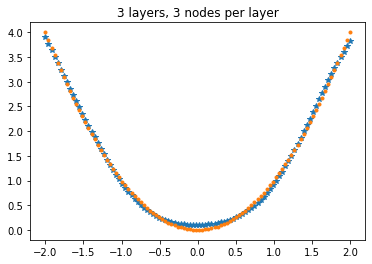

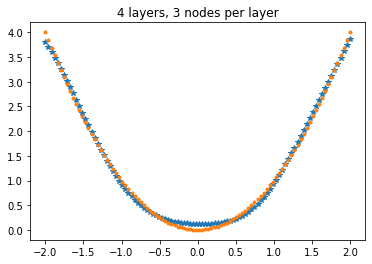

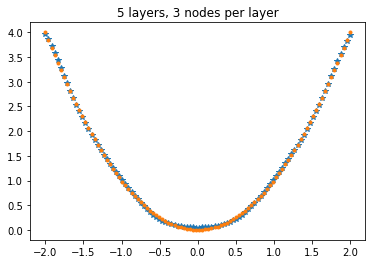

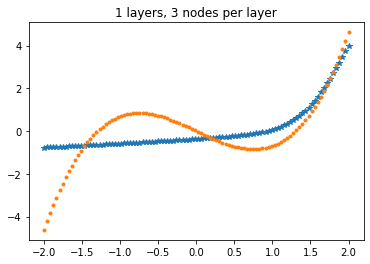

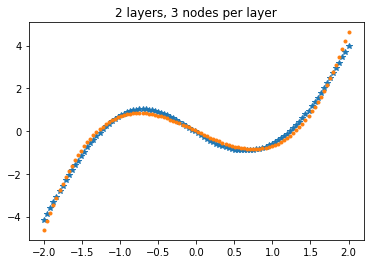

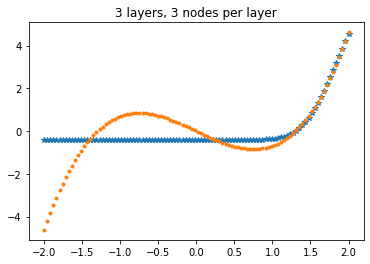

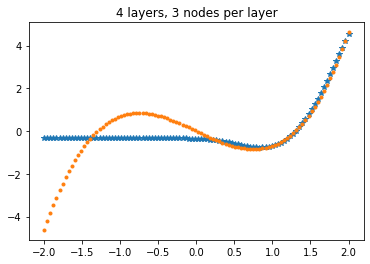

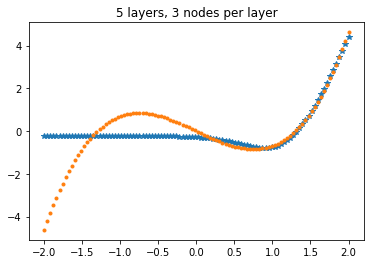

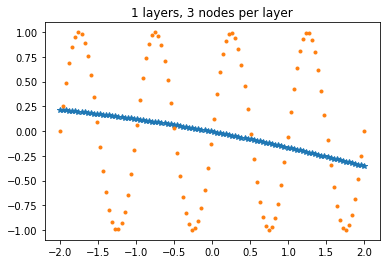

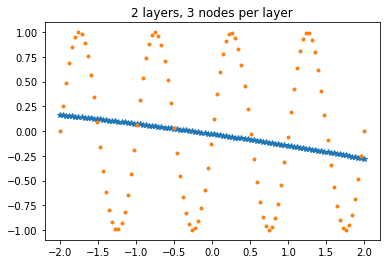

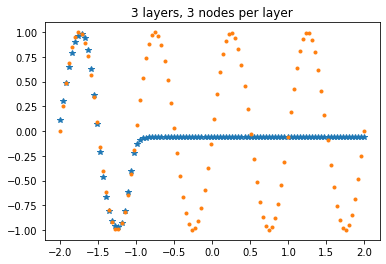

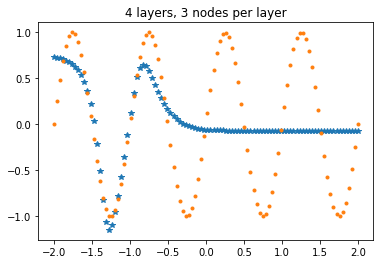

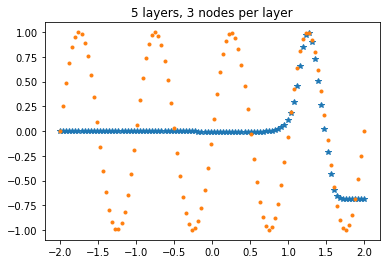

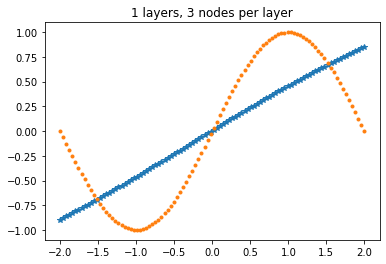

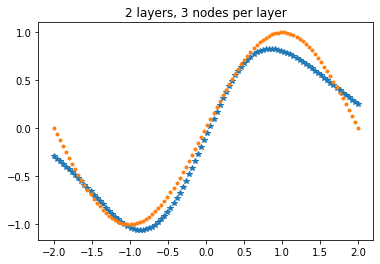

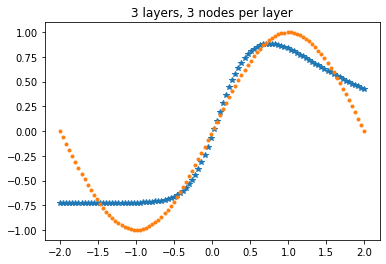

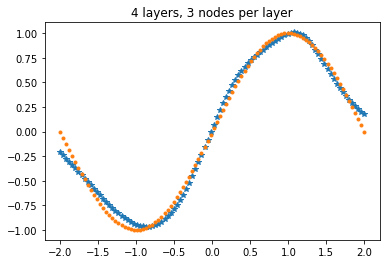

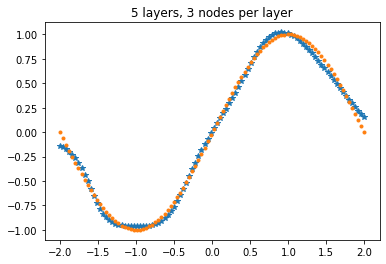

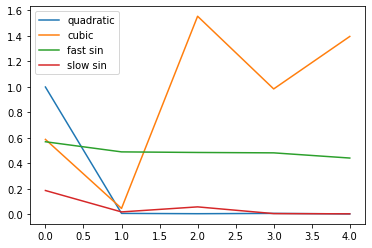

In [ ]:
losses_layers = [[]] * len(datasets)
for j, dataset in enumerate(datasets):
  losses = []
  for i, layer in enumerate(layers):
    plt.figure(1)
    losses.append(train(dataset[0], layer, 3)[-1])
  losses_layers[j] = losses

for j, dataset in enumerate(datasets):
  plt.plot(losses_layers[j], label=dataset[1])
plt.legend()

Welp, I don't think I can make any strong conclusions from these little experiments. I do think it is cool that with as few as six nodes, we can learn quadratic and cubic relationships. 

It does seem like the relation learned is continuous. I imagine we could probably prove this to be true without too much effort -- chances are someone has already done this. After all, the neural network is just a composition of several continuous functions. 

Let's see how large we need to get before we can learn the high frequency sinusoidal relationship.

____________________________________________________________
Epoch: 0.....Train Loss: 0.5202.....Validation Loss: 0.4789
____________________________________________________________
Epoch: 20.....Train Loss: 0.5000.....Validation Loss: 0.4683
____________________________________________________________
Epoch: 40.....Train Loss: 0.4726.....Validation Loss: 0.4929
____________________________________________________________
Epoch: 60.....Train Loss: 0.4648.....Validation Loss: 0.4644
____________________________________________________________
Epoch: 80.....Train Loss: 0.4569.....Validation Loss: 0.4572
____________________________________________________________
Epoch: 100.....Train Loss: 0.4446.....Validation Loss: 0.4318
____________________________________________________________
Epoch: 120.....Train Loss: 0.4189.....Validation Loss: 0.3399
____________________________________________________________
Epoch: 140.....Train Loss: 0.4034.....Validation Loss: 0.3399
______________________

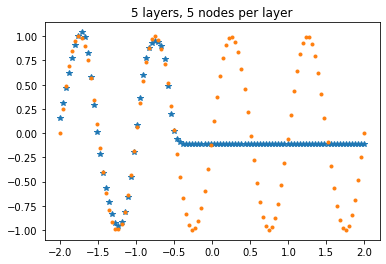

[0.3186578154563904, 0.23125016689300537]

In [ ]:
train(fastsin_data, 5, 5, display=True)

____________________________________________________________
Epoch: 0.....Train Loss: 0.7103.....Validation Loss: 0.5484
____________________________________________________________
Epoch: 20.....Train Loss: 0.4962.....Validation Loss: 0.5069
____________________________________________________________
Epoch: 40.....Train Loss: 0.4919.....Validation Loss: 0.5091
____________________________________________________________
Epoch: 60.....Train Loss: 0.4908.....Validation Loss: 0.5119
____________________________________________________________
Epoch: 80.....Train Loss: 0.4907.....Validation Loss: 0.5133
____________________________________________________________
Epoch: 100.....Train Loss: 0.4907.....Validation Loss: 0.5139
____________________________________________________________
Epoch: 120.....Train Loss: 0.4906.....Validation Loss: 0.5140
____________________________________________________________
Epoch: 140.....Train Loss: 0.4891.....Validation Loss: 0.5119
______________________

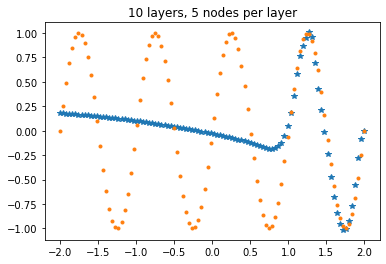

[0.37052690982818604, 0.28845328092575073]

In [ ]:
train(fastsin_data, 10, 5, display=True)

____________________________________________________________
Epoch: 0.....Train Loss: 0.4890.....Validation Loss: 0.7210
____________________________________________________________
Epoch: 20.....Train Loss: 0.4814.....Validation Loss: 0.5320
____________________________________________________________
Epoch: 40.....Train Loss: 0.4743.....Validation Loss: 0.5130
____________________________________________________________
Epoch: 60.....Train Loss: 0.4563.....Validation Loss: 0.5028
____________________________________________________________
Epoch: 80.....Train Loss: 0.4476.....Validation Loss: 0.4958
____________________________________________________________
Epoch: 100.....Train Loss: 0.3984.....Validation Loss: 0.4355
____________________________________________________________
Epoch: 120.....Train Loss: 0.3176.....Validation Loss: 0.4601
____________________________________________________________
Epoch: 140.....Train Loss: 0.2894.....Validation Loss: 0.4035
______________________

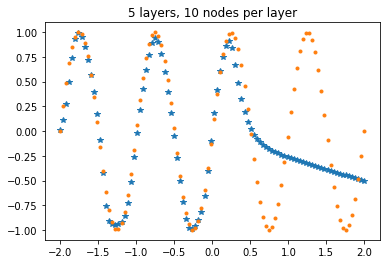

[0.18188560009002686, 0.20915007591247559]

In [ ]:
train(fastsin_data, 5, 10, display=True)